[View in Colaboratory](https://colab.research.google.com/github/jeffreyrnorton/MachineLearningNotes/blob/master/FeedForward2DeepNetwork.ipynb)

# Feed Forward, Deep Nets, and Dropout with Keras

In a previous example, a Fast Forward Network was used to classify the occurence of diabetes among the Pima Indians.  What if start adding more dense layers.  We also investigate dropout.

Import the libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


Get the dataset.  The dataset was originally at the UCI dataset repository, but was removed.  But it is (for now) available on github.

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [2]:
# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

# load pima indians dataset
# download directly from website
dataset = pd.read_csv("https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv", 
                      header=None, skiprows=9).values
# import from local directory
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])



```
Split into training and testing data.
```



In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,0:8], dataset[:,8], 
                                                    test_size=0.25, random_state=87)

We explore some various configurations of feed forward and deep nets (with just two hidden layers).  We also explore adding a dropout layer between the two hidden layers, so actually, there are three hidden layers.

We determine the size of the second layer based off the size of the first hidden layer - $\frac{2}{3}$ the size of the first hidden layer plus the size of the output layer (which is one).

What we are going to discover is that adding extra layers does not always guarantee a better solution.

In [0]:
def run_model(hidden_layer_size, second_hidden_layer=True, dropout = None, epochs=1000):
    np.random.seed(seed)
    model = Sequential() # create model
    model.add(Dense(hidden_layer_size, input_dim=8, activation='relu')) # hidden layer one
    
    if second_hidden_layer:
        if dropout is not None:
            model.add(Dropout(dropout))

        # Now add a second hidden layer
        second_layer_size = int(hidden_layer_size*2/3+1)
    
        model.add(Dense(second_layer_size, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid')) # output layer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    # verbose=0 suppresses the file writing message
    # note that the fit method expects a list of callbacks
    test_over_time = []
    fitting_log = {'loss':[], 'acc':[]}
    for i in range(epochs):
        res = model.fit(X_train, Y_train, epochs=1, verbose=0, batch_size=X_train.shape[0],
                        initial_epoch=0)
        fitting_log['loss'].append(res.history['loss'][0])
        fitting_log['acc'].append(res.history['acc'][0])
        scores = model.evaluate(X_test, Y_test, verbose=0)
        test_over_time.append(scores)
    
    # [loss, accuracy]
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    return model, fitting_log, test_over_time, loss, accuracy

In [0]:
def plot_nn(fitted_log, test_over_time):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(range(len(fitted_log['loss'])), fitted_log['loss'],linestyle='-', color='blue',label='Training', lw=2)
    ax1.plot(range(len(np.array(test_over_time)[:,0])), np.array(test_over_time)[:,0], linestyle='-', color='green',label='Test', lw=2)
    ax2.plot(range(len(fitted_log['acc'])), fitted_log['acc'],linestyle='-', color='blue',label='Training', lw=2)
    ax2.plot(range(len(np.array(test_over_time)[:,1])), np.array(test_over_time)[:,1], linestyle='-', color='green',label='Test', lw=2)
    leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
    ax1.set_xticklabels('')
    #ax1.set_yscale('log')
    ax2.set_xlabel('# Epochs',fontsize=14)
    ax1.set_ylabel('Loss',fontsize=14)
    ax2.set_ylabel('Accuracy',fontsize=14)
    plt.show()

In [0]:
def output_results(model, fitting_log, test_over_time, loss, accuracy):
    # Print a summary of the model
    print(model.summary())
    # A graph of the model (optional)

    # Print the fitting log
    nepochs = len(fitting_log['loss'])
    print('Training loss, accuracy:', [fitting_log['loss'][nepochs-2:nepochs-1], fitting_log['acc'][nepochs-2:nepochs-1]])
    print('Testing loss, accuracy: {} {}'.format(loss, accuracy))
    plot_nn(fitting_log, test_over_time)
    

In order to track all the variations, define a class in which we can encapsulate the different configurations as well as the results.

In [0]:
class configuration:
    def __init__(self, hidden_layer_size, second_hidden_layer=True, dropout = None, epochs=1000):
        self.hidden_layer_size = hidden_layer_size
        self.second_hidden_layer = second_hidden_layer
        self.dropout = dropout
        self.epochs = epochs
        
    def execute(self):
        self.model, self.fitting_log, self.test_over_time, self.loss, self.accuracy = \
           run_model(self.hidden_layer_size, self.second_hidden_layer, self.dropout, self.epochs)
        
    def train_accuracy(self):
        return self.accuracy
    
    def test_accuracy(self):
        return self.fitting_log['acc'][-1]
      
    def description(self):
        s = 'Feed Forward [{}]'.format(self.hidden_layer_size) if not self.second_hidden_layer else \
            'DNN with 2 hidden layers [{}/{}]'.format(self.hidden_layer_size, int(self.hidden_layer_size*2/3+1))
        if self.dropout is not None:
            s += ', Dropout Layer({})'.format(self.dropout)
        return s
    
    def results(self):
        print(self.description())
        output_results(self.model, self.fitting_log, self.test_over_time, self.loss, self.accuracy)

Try many different configurations - this takes a few minutes.

In [0]:
nepochs = 500
cfgs = [configuration(8, False, None, nepochs),
        configuration(24, False, None, nepochs),
        configuration(96, False, None, nepochs),
        configuration(192, False, None, nepochs),
        configuration(384, False, None, nepochs),
        configuration(24, True, None, nepochs),
        configuration(48, True, None, nepochs),
        configuration(96, True, None, nepochs),
        configuration(192, True, None, nepochs),
        configuration(384, True, None, nepochs),
        configuration(24, True, 0.66, nepochs),
        configuration(24, True, 0.50, nepochs),
        configuration(24, True, 0.33, nepochs),
        configuration(48, True, 0.66, nepochs),
        configuration(48, True, 0.50, nepochs),
        configuration(48, True, 0.33, nepochs),
        configuration(96, True, 0.66, nepochs),
        configuration(96, True, 0.50, nepochs),
        configuration(96, True, 0.33, nepochs),
        configuration(192, True, 0.66, nepochs),
        configuration(192, True, 0.50, nepochs),
        configuration(192, True, 0.33, nepochs),
        configuration(384, True, 0.66, nepochs),
        configuration(384, True, 0.50, nepochs),
        configuration(384, True, 0.33, nepochs)
       ]
        

for cfg in cfgs:
    cfg.execute()

In [9]:
for cfg in cfgs:
    print('{} -- Train, Test Accuracies: {}, {}'.format(cfg.description(), cfg.train_accuracy(), cfg.test_accuracy()))

Feed Forward [8] -- Train, Test Accuracies: 0.6770833333333334, 0.7013888955116272
Feed Forward [24] -- Train, Test Accuracies: 0.625, 0.6649305820465088
Feed Forward [96] -- Train, Test Accuracies: 0.7135416666666666, 0.7899305820465088
Feed Forward [192] -- Train, Test Accuracies: 0.7552083333333334, 0.8107638955116272
Feed Forward [384] -- Train, Test Accuracies: 0.7552083333333334, 0.84375
DNN with 2 hidden layers [24/17] -- Train, Test Accuracies: 0.6927083333333334, 0.75
DNN with 2 hidden layers [48/33] -- Train, Test Accuracies: 0.7239583333333334, 0.7934027910232544
DNN with 2 hidden layers [96/65] -- Train, Test Accuracies: 0.7604166666666666, 0.8038194179534912
DNN with 2 hidden layers [192/129] -- Train, Test Accuracies: 0.7395833333333334, 0.8645833134651184
DNN with 2 hidden layers [384/257] -- Train, Test Accuracies: 0.7760416666666666, 0.8489583134651184
DNN with 2 hidden layers [24/17], Dropout Layer(0.66) -- Train, Test Accuracies: 0.65625, 0.6840277910232544
DNN with 

Now the results are interesting.  The metric of greatest interest is the test accuracy.  What will typically happen is that testing accuracy will drop off first as overfitting begins to occur.  Let's take a look at each of the different topologies explored:

### Feed Forward
I find it somewhat surprising that the feed forward network with the largest number of nodes actually does not show apparent overfitting.  Both the training and testing accuracies continue to improve after hitting 24 nodes in the hidden layer.  Note the test accuracy is $0.835$.

### Deep Network - no dropout
With the second hidden layer, we do see overfitting in the model with 384/257 nodes in the two hidden layers.  In this case, the best configuration is the configuration with 182/128 in the two hidden layers with test accuracy of $0.875$ - a slight improvement over the Feed Forward network.

### Deep Network with dropout

The purpose of a dropout layer is to help prevent overfitting.  It is not at all surprising that accuracies have dropped off - but in this case, dropout is clearly detrimental.

### In the End

In the end, while the extra hidden layer does improve the results, it is just not that big of a difference.  Such generalizations do not apply for all problems, but in this case, a feed forward action is sufficient.

# Results of all Configurations


_________________________________________________________________________________________________________
Feed Forward [8]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.6097542643547058], [0.7013888955116272]]
Testing loss, accuracy: 0.6416804095109304 0.6770833333333334


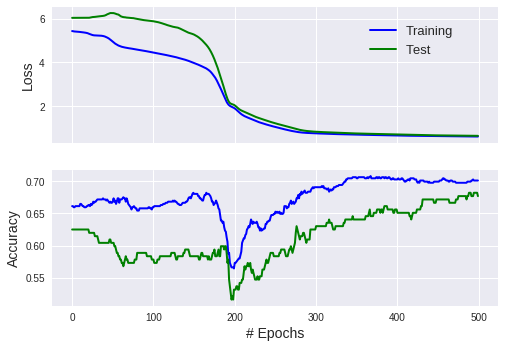


_________________________________________________________________________________________________________
Feed Forward [24]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[5.40085506439209], [0.6649305820465088]]
Testing loss, accuracy: 5.967303315798442 0.625


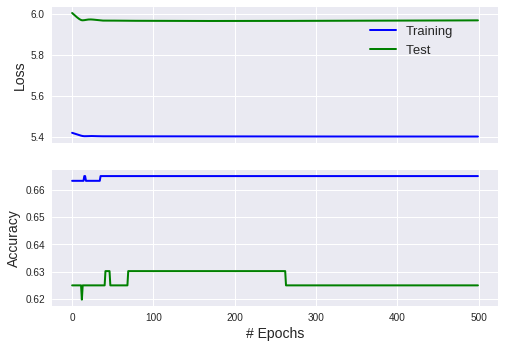


_________________________________________________________________________________________________________
Feed Forward [96]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 96)                864       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 97        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.4626240134239197], [0.7934027910232544]]
Testing loss, accuracy: 0.5627633978923162 0.7135416666666666


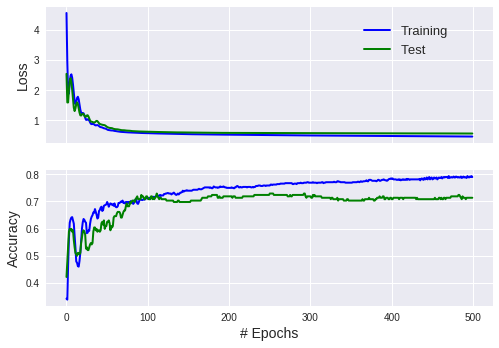


_________________________________________________________________________________________________________
Feed Forward [192]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 192)               1728      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 193       
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.3837033212184906], [0.8229166865348816]]
Testing loss, accuracy: 0.5670212954282761 0.7552083333333334


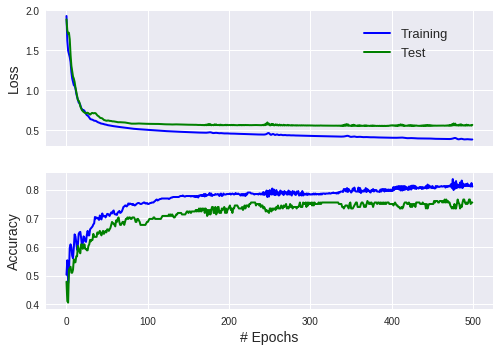


_________________________________________________________________________________________________________
Feed Forward [384]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 384)               3456      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 385       
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.35489609837532043], [0.8402777910232544]]
Testing loss, accuracy: 0.601647729674975 0.7552083333333334


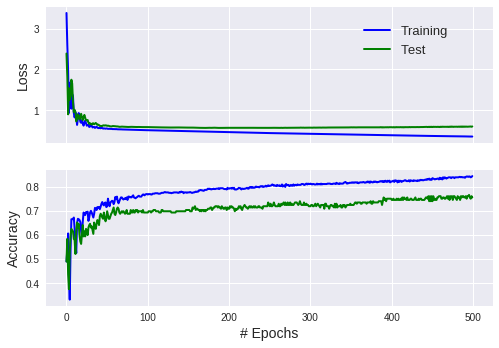


_________________________________________________________________________________________________________
DNN with 2 hidden layers [24/17]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 24)                216       
_________________________________________________________________
dense_12 (Dense)             (None, 17)                425       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 18        
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5104988813400269], [0.7482638955116272]]
Testing loss, accuracy: 0.5869231919447581 0.6927083333333334


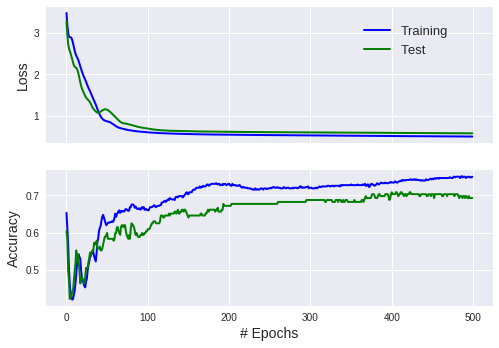


_________________________________________________________________________________________________________
DNN with 2 hidden layers [48/33]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 48)                432       
_________________________________________________________________
dense_15 (Dense)             (None, 33)                1617      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 34        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.43306154012680054], [0.7881944179534912]]
Testing loss, accuracy: 0.6301196416219076 0.7239583333333334


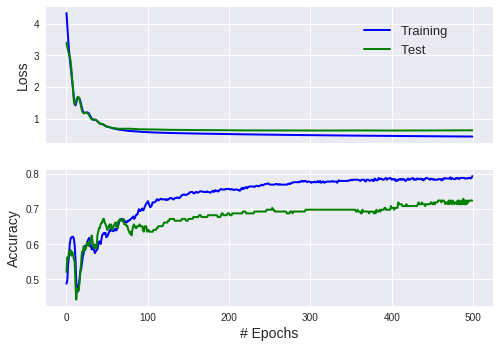


_________________________________________________________________________________________________________
DNN with 2 hidden layers [96/65]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 96)                864       
_________________________________________________________________
dense_18 (Dense)             (None, 65)                6305      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 66        
Total params: 7,235
Trainable params: 7,235
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.407039612531662], [0.8159722089767456]]
Testing loss, accuracy: 0.5770642211039861 0.7604166666666666


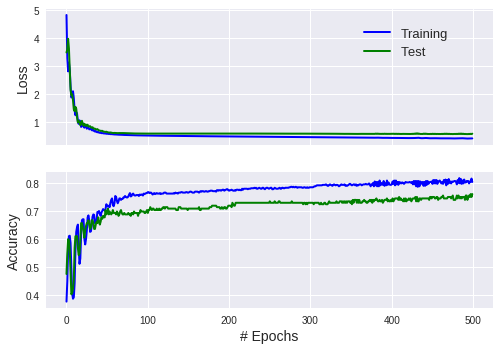


_________________________________________________________________________________________________________
DNN with 2 hidden layers [192/129]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 192)               1728      
_________________________________________________________________
dense_21 (Dense)             (None, 129)               24897     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 130       
Total params: 26,755
Trainable params: 26,755
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.3092876076698303], [0.8767361044883728]]
Testing loss, accuracy: 0.6298919220765432 0.7395833333333334


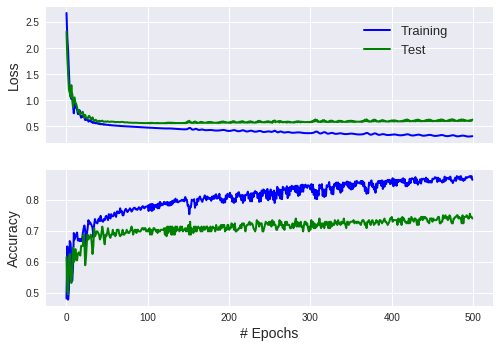


_________________________________________________________________________________________________________
DNN with 2 hidden layers [384/257]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 384)               3456      
_________________________________________________________________
dense_24 (Dense)             (None, 257)               98945     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 258       
Total params: 102,659
Trainable params: 102,659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.3487706482410431], [0.8541666865348816]]
Testing loss, accuracy: 0.7298471033573151 0.7760416666666666


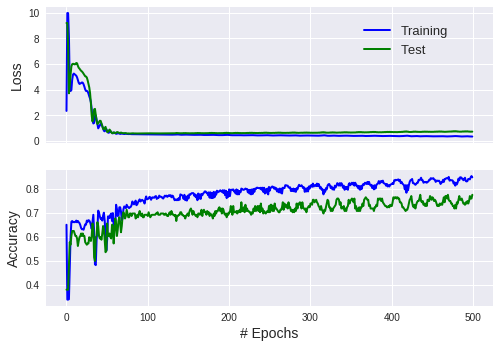


_________________________________________________________________________________________________________
DNN with 2 hidden layers [24/17], Dropout Layer(0.66)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 24)                216       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 17)                425       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 18        
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.6250884532928467], [0.6840277910232544]]
Testing loss, accuracy: 0.65029371281464

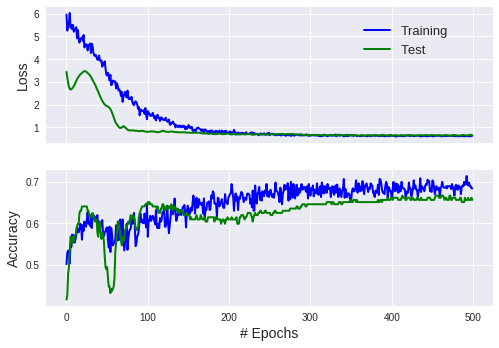


_________________________________________________________________________________________________________
DNN with 2 hidden layers [24/17], Dropout Layer(0.5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 24)                216       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 17)                425       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 18        
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5959732532501221], [0.6857638955116272]]
Testing loss, accuracy: 0.635897388060887

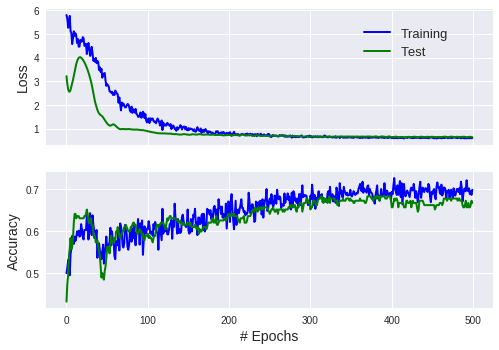


_________________________________________________________________________________________________________
DNN with 2 hidden layers [24/17], Dropout Layer(0.33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 24)                216       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 17)                425       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 18        
Total params: 659
Trainable params: 659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.602966845035553], [0.7083333134651184]]
Testing loss, accuracy: 0.626540750265121

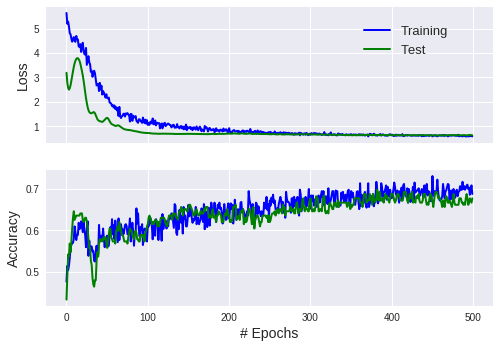


_________________________________________________________________________________________________________
DNN with 2 hidden layers [48/33], Dropout Layer(0.66)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 48)                432       
_________________________________________________________________
dropout_4 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 33)                1617      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 34        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5857643485069275], [0.7083333134651184]]
Testing loss, accuracy: 0.6378499766

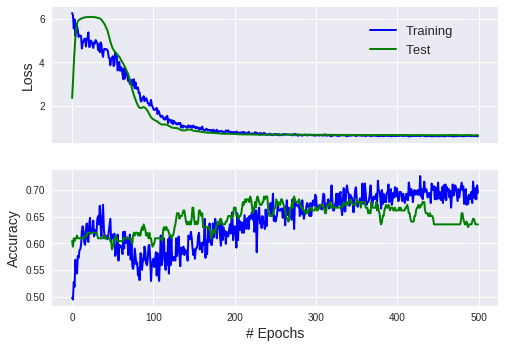


_________________________________________________________________________________________________________
DNN with 2 hidden layers [48/33], Dropout Layer(0.5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 48)                432       
_________________________________________________________________
dropout_5 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 33)                1617      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 34        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5712178945541382], [0.7135416865348816]]
Testing loss, accuracy: 0.62210779388

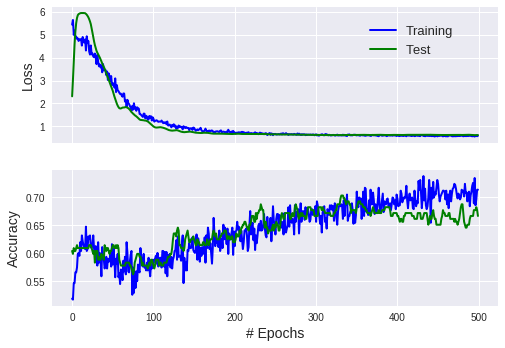


_________________________________________________________________________________________________________
DNN with 2 hidden layers [48/33], Dropout Layer(0.33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 48)                432       
_________________________________________________________________
dropout_6 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 33)                1617      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 34        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5608712434768677], [0.7100694179534912]]
Testing loss, accuracy: 0.5941514074

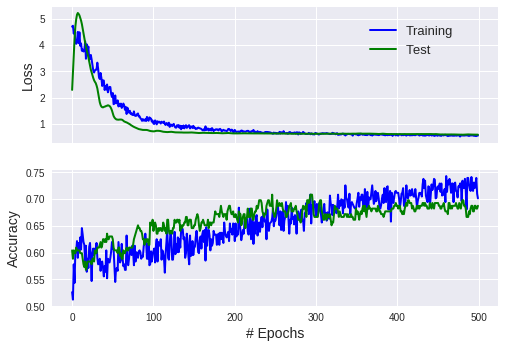


_________________________________________________________________________________________________________
DNN with 2 hidden layers [96/65], Dropout Layer(0.66)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 96)                864       
_________________________________________________________________
dropout_7 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 65)                6305      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 66        
Total params: 7,235
Trainable params: 7,235
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5691738724708557], [0.7065972089767456]]
Testing loss, accuracy: 0.6156150996

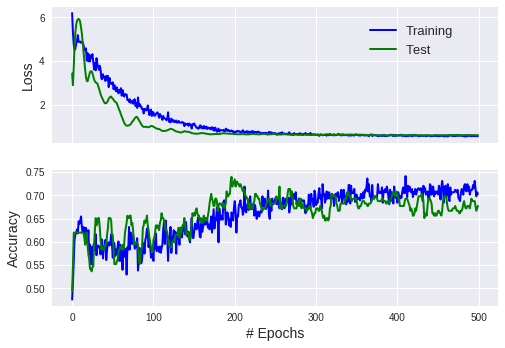


_________________________________________________________________________________________________________
DNN with 2 hidden layers [96/65], Dropout Layer(0.5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 96)                864       
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 65)                6305      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 66        
Total params: 7,235
Trainable params: 7,235
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5371923446655273], [0.7204861044883728]]
Testing loss, accuracy: 0.56593248744

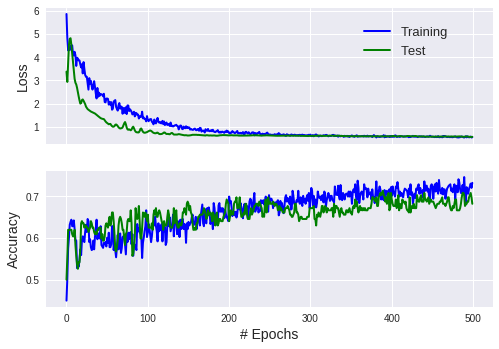


_________________________________________________________________________________________________________
DNN with 2 hidden layers [96/65], Dropout Layer(0.33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 96)                864       
_________________________________________________________________
dropout_9 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 65)                6305      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 66        
Total params: 7,235
Trainable params: 7,235
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5302143096923828], [0.7065972089767456]]
Testing loss, accuracy: 0.5786756773

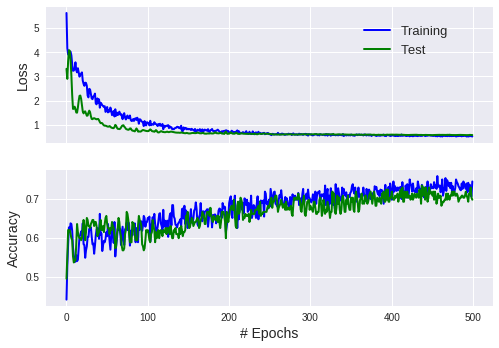


_________________________________________________________________________________________________________
DNN with 2 hidden layers [192/129], Dropout Layer(0.66)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 192)               1728      
_________________________________________________________________
dropout_10 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 129)               24897     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 130       
Total params: 26,755
Trainable params: 26,755
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5222837924957275], [0.7256944179534912]]
Testing loss, accuracy: 0.569374

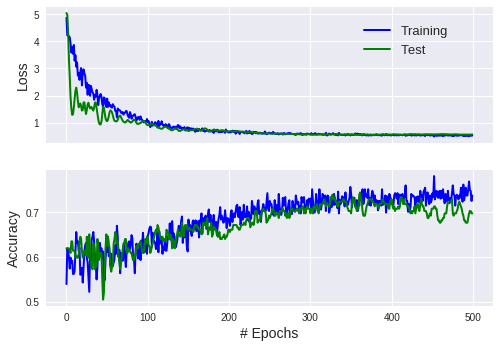


_________________________________________________________________________________________________________
DNN with 2 hidden layers [192/129], Dropout Layer(0.5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 192)               1728      
_________________________________________________________________
dropout_11 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 129)               24897     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 130       
Total params: 26,755
Trainable params: 26,755
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5006697773933411], [0.7569444179534912]]
Testing loss, accuracy: 0.5625233

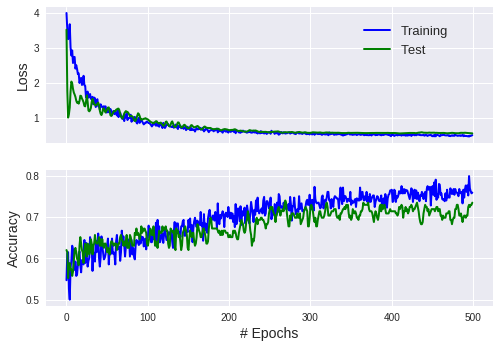


_________________________________________________________________________________________________________
DNN with 2 hidden layers [192/129], Dropout Layer(0.33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 192)               1728      
_________________________________________________________________
dropout_12 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 129)               24897     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 130       
Total params: 26,755
Trainable params: 26,755
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5053618550300598], [0.7621527910232544]]
Testing loss, accuracy: 0.552301

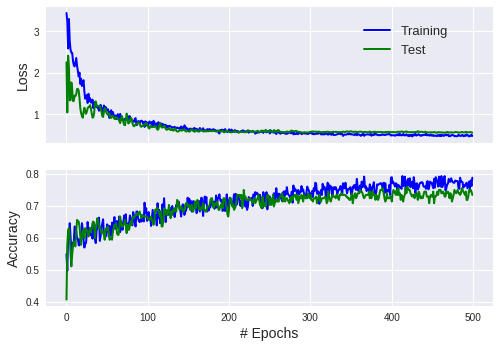


_________________________________________________________________________________________________________
DNN with 2 hidden layers [384/257], Dropout Layer(0.66)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 384)               3456      
_________________________________________________________________
dropout_13 (Dropout)         (None, 384)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 257)               98945     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 258       
Total params: 102,659
Trainable params: 102,659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5346648097038269], [0.7361111044883728]]
Testing loss, accuracy: 0.5712

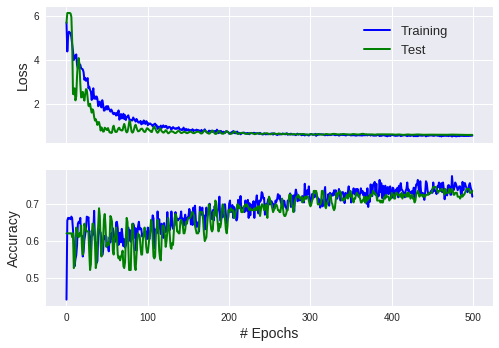


_________________________________________________________________________________________________________
DNN with 2 hidden layers [384/257], Dropout Layer(0.5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 384)               3456      
_________________________________________________________________
dropout_14 (Dropout)         (None, 384)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 257)               98945     
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 258       
Total params: 102,659
Trainable params: 102,659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[0.5202898383140564], [0.7482638955116272]]
Testing loss, accuracy: 0.58448

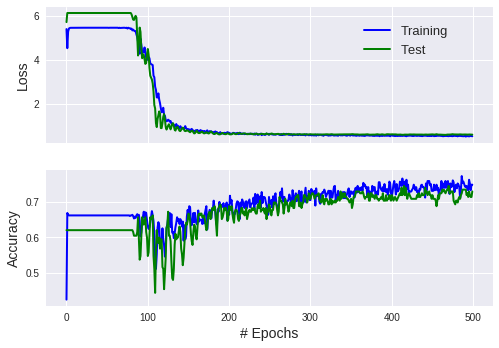


_________________________________________________________________________________________________________
DNN with 2 hidden layers [384/257], Dropout Layer(0.33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 384)               3456      
_________________________________________________________________
dropout_15 (Dropout)         (None, 384)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 257)               98945     
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 258       
Total params: 102,659
Trainable params: 102,659
Non-trainable params: 0
_________________________________________________________________
None
Training loss, accuracy: [[5.456648826599121], [0.6614583134651184]]
Testing loss, accuracy: 6.12823

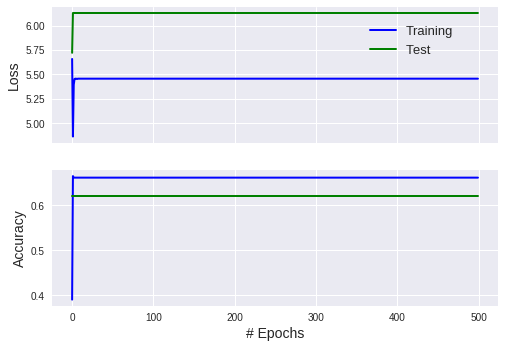

In [10]:
for cfg in cfgs:
    print('')
    print('_________________________________________________________________________________________________________')
    cfg.results()

In [0]:
#SVG(model_to_dot(model_5).create(prog='dot', format='svg'))